## 3.1 Computational Graph

chain rule ∂y/∂u = ∂y/∂v · ∂v/∂u

In [26]:
import numpy as np

def sigmoid(x):
    # Stable sigmoid: handles large |x| values safely
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))
    
def numeric_jacobian(func, x, h=1e-5):
    """Vector-valued func, vector x -> Jacobian matrix"""
    x = np.asarray(x, dtype=float)
    y0 = func(x)
    m, n = len(y0), len(x)
    J = np.empty((m, n))
    for j in range(n):
        dx = np.zeros_like(x)
        dx[j] = h
        J[:, j] = (func(x + dx) - func(x - dx)) / (2 * h)
    return J

In [27]:
class CompGraph:
    def __init__(self):
        # storage for intermediate values
        self.x1 = self.x2 = self.x3 = None
        self.z1 = self.z2 = self.z3 = None
        self.u1 = self.u2 = self.u3 = None
        self.v1 = self.v2 = self.v3 = None
        self.y1 = self.y2 = None

    def forward(self, x1, x2, x3):
        self.x1, self.x2, self.x3 = x1, x2, x3
        self.z1 = 2*x1 + x2
        self.z2 = x1 * 3*x3
        self.z3 = -x3 * 2*x2
        self.u1 = np.sin(self.z1)
        self.u2 = 6*x3 + 2*self.z2
        self.u3 = 2*self.z1 + self.z3
        self.v1 = self.u1 + np.cos(self.u3)
        self.v2 = np.sin(-self.u2)
        self.v3 = self.u1 * self.u3
        self.y1 = self.v1**2 + self.v2**3
        self.y2 = self.v2 * self.v3
        return np.array([self.y1, self.y2])

    # ---------- analytic back-prop ----------
    def backward(self):
        # dy/dv  (2×3)
        dy1_dv1 = 2 * self.v1
        dy1_dv2 = 3 * self.v2**2
        dy1_dv3 = 0.0
        dy2_dv1 = 0.0
        dy2_dv2 = self.v3
        dy2_dv3 = self.v2
        J_yv = np.array([[dy1_dv1, dy1_dv2, dy1_dv3],
                         [dy2_dv1, dy2_dv2, dy2_dv3]])

        # dv/du  (3×3)
        dv1_du1 = 1.0
        dv1_du2 = 0.0
        dv1_du3 = -np.sin(self.u3)
        dv2_du1 = 0.0
        dv2_du2 = -np.cos(-self.u2)
        dv2_du3 = 0.0
        dv3_du1 = self.u3
        dv3_du2 = 0.0
        dv3_du3 = self.u1
        J_vu = np.array([[dv1_du1, dv1_du2, dv1_du3],
                         [dv2_du1, dv2_du2, dv2_du3],
                         [dv3_du1, dv3_du2, dv3_du3]])

        # dy/du  (2×3)
        J_yu = J_yv @ J_vu

        return J_yv, J_vu, J_yu


# ---------- run ----------
x = np.array([1., 1., 1.])
model = CompGraph()
y = model.forward(*x)
J_yv, J_vu, J_yu = model.backward()

print("Forward output y1, y2 =", y)
print()
print("J_yv = ∂y/∂v\n", J_yv)
print()
print("J_vu = ∂v/∂u\n", J_vu)
print()
print("J_yu = ∂y/∂u (analytic)\n", J_yu)
print()
print("Chain-rule check: J_yv @ J_vu\n", J_yv @ J_vu)

Forward output y1, y2 = [0.41716543 0.3028847 ]

J_yv = ∂y/∂v
 [[-1.02504723  0.86373149  0.        ]
 [ 0.          0.56448003  0.53657292]]

J_vu = ∂v/∂u
 [[ 1.          0.          0.7568025 ]
 [ 0.         -0.84385396  0.        ]
 [ 4.          0.          0.14112001]]

J_yu = ∂y/∂u (analytic)
 [[-1.02504723 -0.72886324 -0.7757583 ]
 [ 2.14629167 -0.47633871  0.07572117]]

Chain-rule check: J_yv @ J_vu
 [[-1.02504723 -0.72886324 -0.7757583 ]
 [ 2.14629167 -0.47633871  0.07572117]]


In [28]:
"""
2-hidden-layer FFNN implemented with NumPy for the OCR dataset.
- Switch datasets by changing `dataset_size = 'small'|'medium'|'large'`.
- Switch activation with activation_type = 'sigmoid' or 'relu'.
"""
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [29]:
# -----------------------------
# Configuration / hyperparams
# -----------------------------
# dataset_size = 'large'   # 'small', 'medium', or 'large'
datasets = ['small', 'medium', 'large']

# Network architecture
H1 = 128   # hidden layer 1 units
H2 = 62   # hidden layer 2 units

label_map = {0:'a',1:'e',2:'g',3:'i',4:'l',5:'n',6:'o',7:'r',8:'t',9:'u'}

# Training hyperparameters
epochs = 20
batch_size = 64
lr = 0.5
activation_type = 'sigmoid'  # 'sigmoid' or 'relu'

seed = 0
np.random.seed(seed)

In [65]:
# -----------------------------
# Utility math & activations
# -----------------------------
def sigmoid(x):
    # Prevent overflow in exp() by clipping extreme values
    x = np.clip(x, -60, 60)
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_grad_from_sigma(sig_x):
    # If sig_x = σ(x), then σ'(x) = σ(x)*(1-σ(x))
    return sig_x * (1.0 - sig_x)

def relu(x):
    # ReLU(x) = max(0, x) (elementwise)
    return np.maximum(0.0, x)

def relu_grad(x):
    # ReLU'(x) = 1 if x > 0 else 0 (elementwise)
    g = np.zeros_like(x)
    g[x > 0] = 1.0
    return g

def softmax(logits):
    """
    Softmax row-wise with numeric stability
    For row i: softmax_i_j = exp(logit_i_j - m_i) / sum_k exp(logit_i_k - m_i)
    where m_i = max_k logit_i_k
    """
    # shift = logits - m (broadcast)
    m = np.max(logits, axis=1, keepdims=True)          # m_i = max_k logits[i,k]   (shape N x 1)
    shift = logits - m                                 # shift[i,j] = logits[i,j] - m_i
    exp_shift = np.exp(shift)                          # exp_shift[i,j] = exp(shift[i,j])
    sum_exp = np.sum(exp_shift, axis=1, keepdims=True) # sum_exp[i] = sum_k exp_shift[i,k]
    probs = exp_shift / sum_exp                        # probs[i,j] = exp_shift[i,j] / sum_exp[i]
    return probs

def cross_entropy_loss(probs, y_onehot):
    """
    L = - (1/N) * sum_{i=1..N} sum_{k=1..K} y_{i,k} * log(probs_{i,k})
    We clip probs to avoid log(0).
    """
    N = probs.shape[0]
    clipped = np.clip(probs, 1e-12, 1.0)
    return -np.sum(y_onehot * np.log(clipped)) / N



===== DATASET: SMALL =====


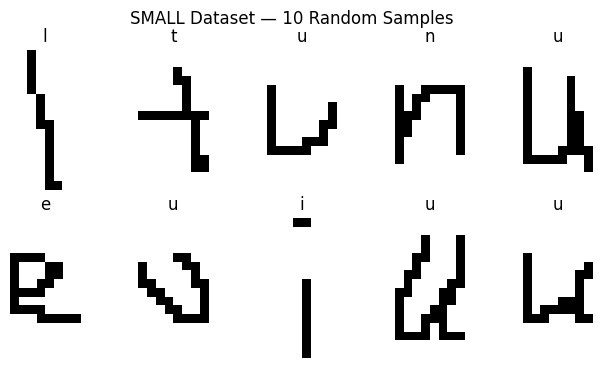


===== DATASET: MEDIUM =====


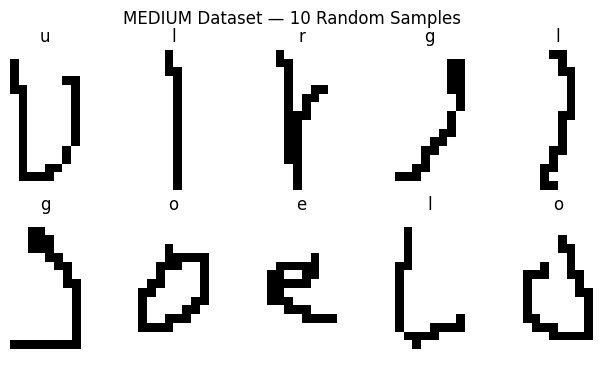


===== DATASET: LARGE =====


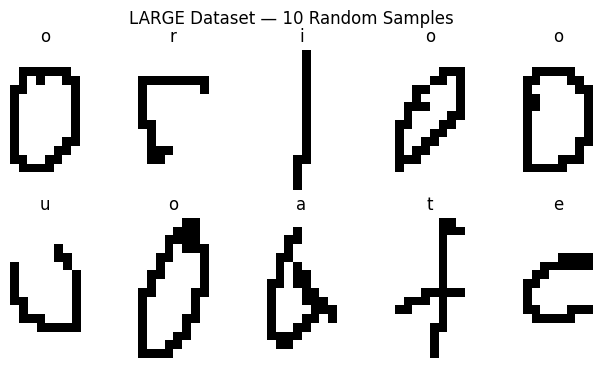

In [64]:
def load_dataset(train_path, split_ratio=0.2):
    """
    Load {dataset_size}Train.csv and split into train/test internally (no Validation.csv).
    Splits each dataset into (1 - split_ratio) train and split_ratio test.
    """
    train_path = os.path.join(f"./图像分类-dataset/{dataset_size}Train.csv")
    df = pd.read_csv(train_path, header=None)

    # separate labels and pixel data
    y = df.iloc[:, 0].values.astype(int)  # labels (shape N,)
    X = df.iloc[:, 1:].values.astype(np.float32)  # pixels (shape N x 128)

    # normalize to [0,1]
    if X.max() > 1.0:
        X /= 255.0  # elementwise: X[i,j] = X[i,j] / 255

    # split into train/test
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=split_ratio, stratify=y, random_state=0
    )

    # one-hot encode labels for loss (K classes)
    enc = OneHotEncoder(sparse_output=False, categories='auto')
    y_train_onehot = enc.fit_transform(y_train.reshape(-1, 1))  # shape (N_train, K)
    y_val_onehot = enc.transform(y_val.reshape(-1, 1))  # shape (N_val, K)

    return X_train, y_train, y_train_onehot, X_val, y_val, y_val_onehot

# M = X_train.shape[1]   # input dim (128)
# K = y_train_onehot.shape[1]  # number of classes, expected 10

def show_samples(X, y, dataset_name):
    indices = np.random.choice(len(X), 10, replace=False)
    fig, axes = plt.subplots(2,5, figsize=(8,4))
    for ax, idx in zip(axes.flatten(), indices):
        ax.imshow(1 - X[idx].reshape(16,8), cmap='gray', vmin=0, vmax=1)
        ax.set_title(f'{label_map[y[idx]]}')
        ax.axis('off')
    plt.suptitle(f'{dataset_name.upper()} Dataset — 10 Random Samples')
    plt.show()
    
for name in datasets:
    print(f"\n===== DATASET: {name.upper()} =====")
    X_train, y_train, y_train_1hot, X_val, y_val, y_val_1hot = load_dataset(train_path, split_ratio=0.2)
    show_samples(X_train, y_train, name)

In [32]:
# -----------------------------
# Helper: choose activation
# -----------------------------
def activation_forward(z):
    if activation_type == 'sigmoid':
        return sigmoid(z)        # a = σ(z)
    elif activation_type == 'relu':
        return relu(z)           # a = max(0, z)
    else:
        raise ValueError("activation_type must be 'sigmoid' or 'relu'")

def activation_backward(z, a):
    """
    Return derivative φ'(z).
    For sigmoid: we pass a = σ(z) and compute σ'(z) = a*(1-a).
    For ReLU: need to compute indicator(z>0).
    """
    if activation_type == 'sigmoid':
        return sigmoid_grad_from_sigma(a)  # φ'(z) elementwise
    elif activation_type == 'relu':
        return relu_grad(z)
    else:
        raise ValueError("activation_type must be 'sigmoid' or 'relu'")

In [39]:
# -----------------------------
# Training loop
# -----------------------------
def train_model(X_train, y_train, y_train_1hot,
                X_test, y_test, y_test_1hot,
                learning_rate=0.5, epochs=200, batch_size=64,
                activation_function='relu'):
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    loss_history = []

    # -----------------------------
    # Parameter initialization
    # -----------------------------
    # Xavier / Glorot-like initialization: normal(0, sqrt(2/(n_in + n_out)))
    W1 = np.random.normal(0.0, np.sqrt(2.0 / (M + H1)), size=(M, H1))   # shape (M, H1)
    b1 = np.zeros((1, H1))                                               # shape (1, H1)
    
    W2 = np.random.normal(0.0, np.sqrt(2.0 / (H1 + H2)), size=(H1, H2))  # shape (H1, H2)
    b2 = np.zeros((1, H2))                                               # shape (1, H2)
    
    W3 = np.random.normal(0.0, np.sqrt(2.0 / (H2 + K)), size=(H2, K))    # shape (H2, K)
    b3 = np.zeros((1, K)) 

    # alias learning_rate for consistency with original lr variable
    lr = learning_rate

    for epoch in range(1, epochs + 1):
        # shuffle dataset each epoch
        X_shuf, y_shuf, yoh_shuf = shuffle(X_train, y_train, y_train_1hot, random_state=epoch)
        epoch_loss_sum = 0.0

        for b in range(num_batches):
            start = b * batch_size
            end = min((b+1) * batch_size, X_shuf.shape[0])
            Xb = X_shuf[start:end]        # shape (N, M)
            yb = yoh_shuf[start:end]      # shape (N, K)
            N = Xb.shape[0]

            # --------------------------
            # Forward propagation
            # --------------------------
            z1 = Xb.dot(W1) + b1          # shape (N, H1)
            a1 = activation_forward(z1)   # shape (N, H1)
            z2 = a1.dot(W2) + b2          # shape (N, H2)
            a2 = activation_forward(z2)   # shape (N, H2)
            z3 = a2.dot(W3) + b3          # shape (N, K)
            probs = softmax(z3)           # shape (N, K)

            # loss (average cross-entropy over batch)
            loss = cross_entropy_loss(probs, yb)
            epoch_loss_sum += loss * N

            # --------------------------
            # Backward propagation
            # --------------------------
            delta3 = (probs - yb) / N     # shape (N, K)
            dW3 = a2.T.dot(delta3)        # shape (H2, K)
            db3 = np.sum(delta3, axis=0, keepdims=True)  # shape (1, K)

            temp2 = delta3.dot(W3.T)      # shape (N, H2)
            delta2 = temp2 * activation_backward(z2, a2)  # shape (N, H2)
            dW2 = a1.T.dot(delta2)        # shape (H1, H2)
            db2 = np.sum(delta2, axis=0, keepdims=True)  # shape (1, H2)

            temp1 = delta2.dot(W2.T)      # shape (N, H1)
            delta1 = temp1 * activation_backward(z1, a1)  # shape (N, H1)
            dW1 = Xb.T.dot(delta1)        # shape (M, H1)
            db1 = np.sum(delta1, axis=0, keepdims=True)  # shape (1, H1)

            # --------------------------
            # Parameter update (SGD)
            # --------------------------
            W3 -= lr * dW3; b3 -= lr * db3
            W2 -= lr * dW2; b2 -= lr * db2
            W1 -= lr * dW1; b1 -= lr * db1

        # --------------------------
        # End of epoch: compute loss and accuracy
        # --------------------------
        epoch_loss = epoch_loss_sum / X_train.shape[0]
        loss_history.append(epoch_loss)

        # Validation / test forward pass
        z1_v = X_test.dot(W1) + b1
        a1_v = activation_forward(z1_v)
        z2_v = a1_v.dot(W2) + b2
        a2_v = activation_forward(z2_v)
        z3_v = a2_v.dot(W3) + b3
        probs_v = softmax(z3_v)
        preds_v = np.argmax(probs_v, axis=1)
        val_acc = np.mean(preds_v == y_test)

        if (epoch % 20 == 0) or (epoch == 1):
            print(f"Epoch {epoch:3d}/{epochs} — Train Loss: {epoch_loss:.4f}, Test Acc: {val_acc*100:.2f}%")

    np.savez(os.path.join(f"./ffnn_{dataset_size}_{activation_type}_params.npz"),
         W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3)
    print("\nFinished training. Parameters saved to disk.")
    # Return everything needed for later analysis
    return loss_history, val_acc, preds_v, probs_v



===== TRAINING ON SMALL DATASET =====
Epoch   1/20 — Train Loss: 2.3627, Test Acc: 18.00%
Epoch  20/20 — Train Loss: 1.3454, Test Acc: 48.00%

Finished training. Parameters saved to disk.
Final Accuracy on SMALL: 48.00%

===== TRAINING ON MEDIUM DATASET =====
Epoch   1/20 — Train Loss: 2.2854, Test Acc: 27.50%
Epoch  20/20 — Train Loss: 0.4890, Test Acc: 82.60%

Finished training. Parameters saved to disk.
Final Accuracy on MEDIUM: 82.60%

===== TRAINING ON LARGE DATASET =====
Epoch   1/20 — Train Loss: 2.0824, Test Acc: 37.67%
Epoch  20/20 — Train Loss: 0.3713, Test Acc: 85.39%

Finished training. Parameters saved to disk.
Final Accuracy on LARGE: 85.39%


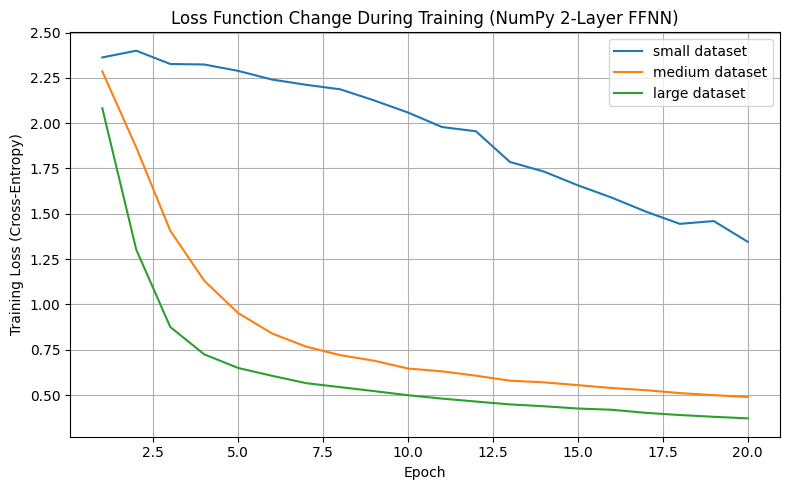


Summary of Final Accuracies:
Small     : 48.00%
Medium    : 82.60%
Large     : 85.39%


In [40]:
# ==============================================================
# Plot Loss Function Changes for Small, Medium, and Large Datasets
# ==============================================================

loss_curves = {}
accuracies = {}

for dataset_size in ['small', 'medium', 'large']:
    print(f"\n===== TRAINING ON {dataset_size.upper()} DATASET =====")

    X_train, y_train, y_train_1hot, X_val, y_val, y_val_1hot = load_dataset(train_path, split_ratio=0.2)

    # Recalculate input/output dimensions for this dataset
    M = X_train.shape[1]
    K = y_train_1hot.shape[1]

    # Train the model using your existing train_model() function
    loss_history, val_acc, preds, probs = train_model(
        X_train, y_train, y_train_1hot,
        X_val, y_val, y_val_1hot,
        learning_rate=lr, epochs=epochs, batch_size=batch_size,
        activation_function=activation_type
    )

    loss_curves[dataset_size] = loss_history
    accuracies[dataset_size] = val_acc

    print(f"Final Accuracy on {dataset_size.upper()}: {val_acc*100:.2f}%")

# --------------------------------------------------------------
# Plot all three loss curves on the same graph for comparison
# --------------------------------------------------------------
plt.figure(figsize=(8,5))
for name, losses in loss_curves.items():
    plt.plot(range(1, len(losses)+1), losses, label=f"{name} dataset")

plt.xlabel("Epoch")
plt.ylabel("Training Loss (Cross-Entropy)")
plt.title("Loss Function Change During Training (NumPy 2-Layer FFNN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# Print summary of final accuracies
# --------------------------------------------------------------
print("\nSummary of Final Accuracies:")
for ds, acc in accuracies.items():
    print(f"{ds.capitalize():<10}: {acc*100:.2f}%")

# Save final weights if desired




===== SMALL DATASET — 5 SAMPLE PREDICTIONS =====
Epoch   1/20 — Train Loss: 2.3738, Test Acc: 12.00%
Epoch  20/20 — Train Loss: 1.3927, Test Acc: 50.00%


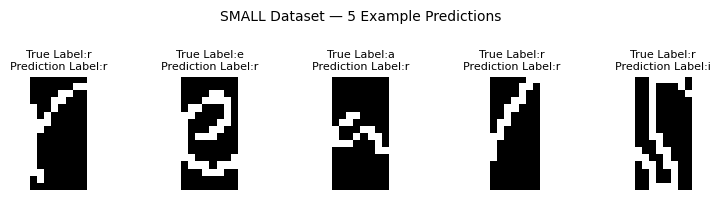


===== MEDIUM DATASET — 5 SAMPLE PREDICTIONS =====
Epoch   1/20 — Train Loss: 2.2570, Test Acc: 27.20%
Epoch  20/20 — Train Loss: 0.4794, Test Acc: 82.60%


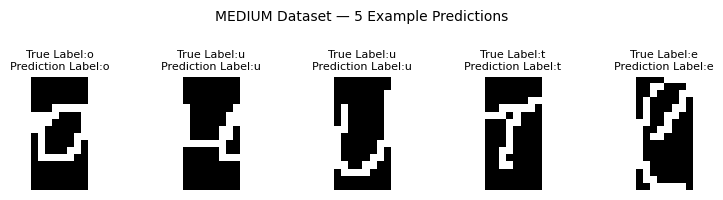


===== LARGE DATASET — 5 SAMPLE PREDICTIONS =====
Epoch   1/20 — Train Loss: 2.0572, Test Acc: 37.39%
Epoch  20/20 — Train Loss: 0.3795, Test Acc: 85.61%


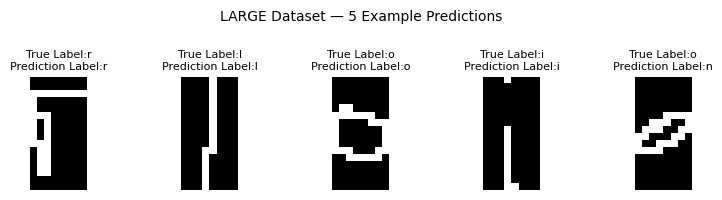

In [36]:
# ==============================================================
# Show 5 test samples (image + True/Predicted labels) per dataset
# ==============================================================

for dataset_size in ['small', 'medium', 'large']:
    print(f"\n===== {dataset_size.upper()} DATASET — 5 SAMPLE PREDICTIONS =====")

    # Load dataset (split internally into train/test)
    train_path = os.path.join(f"./图像分类-dataset/{dataset_size}Train.csv")
    X_train, y_train, y_train_1hot, X_val, y_val, y_val_1hot = load_dataset(train_path, split_ratio=0.2)

    # Infer input/output dimensions
    M = X_train.shape[1]
    K = y_train_1hot.shape[1]

    # Train model
    loss_history, val_acc, preds_v, probs_v = train_model(
        X_train, y_train, y_train_1hot,
        X_val, y_val, y_val_1hot,
        learning_rate=lr, epochs=epochs, batch_size=batch_size,
        activation_function=activation_type
    )

    # Pick 5 random test samples
    sample_indices = np.random.choice(len(X_val), 5, replace=False)
    fig, axes = plt.subplots(1, 5, figsize=(8, 2))

    for i, ax in enumerate(axes):
        idx = sample_indices[i]
        image = X_val[idx].reshape(16, 8)
        true_label = label_map[y_val[idx]]
        pred_label = label_map[preds_v[idx]]

        ax.imshow(image, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"True Label:{true_label}\nPrediction Label:{pred_label}", fontsize=8)
        ax.axis('off')

    plt.suptitle(f"{dataset_size.upper()} Dataset — 5 Example Predictions", fontsize=10)
    plt.tight_layout()
    plt.show()


In [109]:
# ==============================================================
# 1. Load Datasets
# ==============================================================

train_df = pd.read_csv("./回归-dataset/data_train.csv", header=None, skiprows=1)
valid_df = pd.read_csv("./回归-dataset/data_valid.csv", header=None, skiprows=1)
test_df  = pd.read_csv("./回归-dataset/data_test.csv", header=None, skiprows=1)

# Convert to NumPy arrays
X_all = train_df.iloc[:, 0].to_numpy(dtype=float).reshape(-1, 1)
Y_all = train_df.iloc[:, 1].to_numpy(dtype=float).reshape(-1, 1)

# Random shuffle and split data_train.csv
np.random.seed(42)
indices = np.random.permutation(len(X_all))
X_all, Y_all = X_all[indices], Y_all[indices]

X_train, Y_train = X_all[:1800], Y_all[:1800]   # In-distribution train
X_test_ID, Y_test_ID = X_all[1800:], Y_all[1800:]  # In-distribution test

# Combine valid + test for OOD (out-of-distribution)
X_test_OOD = np.concatenate([valid_df.iloc[:, 0].values.reshape(-1, 1),
                             test_df.iloc[:, 0].values.reshape(-1, 1)])
Y_test_OOD = np.concatenate([valid_df.iloc[:, 1].values.reshape(-1, 1),
                             test_df.iloc[:, 1].values.reshape(-1, 1)])

print("Train + Test is ", X_all.shape, "not 2400")
print("Train:", X_train.shape, "Test(ID):", X_test_ID.shape, "Test(OOD):", X_test_OOD.shape)

Train + Test is  (2190, 1) not 2400
Train: (1800, 1) Test(ID): (390, 1) Test(OOD): (1460, 1)


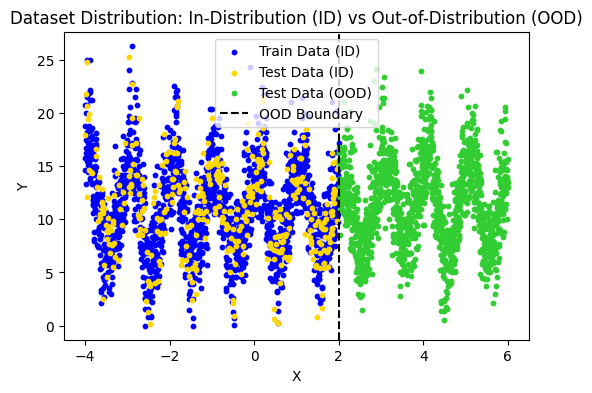

In [110]:
# ==============================================================
# 2. Visualize In-Distribution and Out-of-Distribution Sets
# ==============================================================

plt.figure(figsize=(6,4))
plt.scatter(X_train, Y_train, s=10, c='blue', label="Train Data (ID)")
plt.scatter(X_test_ID, Y_test_ID, s=10, c='gold', label="Test Data (ID)")
plt.scatter(X_test_OOD, Y_test_OOD, s=10, c='limegreen', label="Test Data (OOD)")
plt.axvline(x=2.0, color='black', linestyle='--', label="OOD Boundary")
plt.legend()
plt.title("Dataset Distribution: In-Distribution (ID) vs Out-of-Distribution (OOD)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [112]:
def batch_norm(x, eps=1e-8):
    # Batch Normalization for stability (normalize each mini-batch)
    mu = np.mean(x, axis=0, keepdims=True)
    sigma = np.std(x, axis=0, keepdims=True)
    return (x - mu) / (sigma + eps)

def sigmoid(x):
    # Prevent overflow in exp() by clipping extreme values
    x = np.clip(x, -60, 60)
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_grad_from_sigma(sig_x):
    # If sig_x = σ(x), then σ'(x) = σ(x)*(1-σ(x))
    return sig_x * (1.0 - sig_x)


def mse_loss(y_pred, y_true):
    """
    Mean Squared Error Loss:
    L = 1/2 * (y - ŷ)^2
    """
    return 0.5 * np.mean((y_true - y_pred) ** 2)

def mse_grad(y_pred, y_true):
    # Gradient of MSE w.r.t output ŷ
    return (y_pred - y_true)

def normalize_data(X_train, Y_train, X_test_ID, Y_test_ID, X_test_OOD, Y_test_OOD):
    """Normalize X and Y using training statistics."""
    X_mean, X_std = np.mean(X_train), np.std(X_train)
    Y_mean, Y_std = np.mean(Y_train), np.std(Y_train)

    def norm(X, Y):
        return (X - X_mean) / X_std, (Y - Y_mean) / Y_std

    X_train_n, Y_train_n = norm(X_train, Y_train)
    X_test_ID_n, Y_test_ID_n = norm(X_test_ID, Y_test_ID)
    X_test_OOD_n, Y_test_OOD_n = norm(X_test_OOD, Y_test_OOD)
    return X_train_n, Y_train_n, X_test_ID_n, Y_test_ID_n, X_test_OOD_n, Y_test_OOD_n


In [120]:
def train_numpy_ffnn(X_train, Y_train, X_test_ID, Y_test_ID, X_test_OOD, Y_test_OOD,
                     hidden1=64, hidden2=32, lr=0.001, epochs=20000, bn=True):
    """
    NumPy FFNN regression (2 hidden layers).
    Uses Sigmoid activations and optional Batch Normalization.
    """

    np.random.seed(42)
    W1 = np.random.randn(1, hidden1) * np.sqrt(2.0 / (1 + hidden1))
    b1 = np.zeros((1, hidden1))
    W2 = np.random.randn(hidden1, hidden2) * np.sqrt(2.0 / (hidden1 + hidden2))
    b2 = np.zeros((1, hidden2))
    W3 = np.random.randn(hidden2, 1) * np.sqrt(2.0 / (hidden2 + 1))
    b3 = np.zeros((1, 1))

    train_loss_list, test_loss_ID_list, test_loss_OOD_list = [], [], []

    for epoch in range(epochs + 1):
        # ---- Forward ----
        z1 = X_train.dot(W1) + b1
        a1 = sigmoid(batch_norm(z1) if bn else z1)

        z2 = a1.dot(W2) + b2
        a2 = sigmoid(batch_norm(z2) if bn else z2)

        z3 = a2.dot(W3) + b3
        y_pred = z3

        loss = mse_loss(y_pred, Y_train)

        # ---- Backward ----
        dL_dy = y_pred - Y_train
        dL_dW3 = a2.T.dot(dL_dy) / len(X_train)
        dL_db3 = np.mean(dL_dy, axis=0, keepdims=True)

        delta2 = (dL_dy.dot(W3.T)) * sigmoid_grad_from_sigma(a2)
        dL_dW2 = a1.T.dot(delta2) / len(X_train)
        dL_db2 = np.mean(delta2, axis=0, keepdims=True)

        delta1 = (delta2.dot(W2.T)) * sigmoid_grad_from_sigma(a1)
        dL_dW1 = X_train.T.dot(delta1) / len(X_train)
        dL_db1 = np.mean(delta1, axis=0, keepdims=True)

        # Clip gradients
        for grad in [dL_dW1, dL_dW2, dL_dW3, dL_db1, dL_db2, dL_db3]:
            np.clip(grad, -5, 5, out=grad)

        # ---- Update ----
        W1 -= lr * dL_dW1
        b1 -= lr * dL_db1
        W2 -= lr * dL_dW2
        b2 -= lr * dL_db2
        W3 -= lr * dL_dW3
        b3 -= lr * dL_db3

        # ---- Evaluate ----
        if epoch % 1000 == 0:
            def forward(X):
                z1 = X.dot(W1) + b1
                a1 = sigmoid(batch_norm(z1) if bn else z1)
                z2 = a1.dot(W2) + b2
                a2 = sigmoid(batch_norm(z2) if bn else z2)
                z3 = a2.dot(W3) + b3
                return z3

            train_loss_list.append(mse_loss(forward(X_train), Y_train))
            test_loss_ID_list.append(mse_loss(forward(X_test_ID), Y_test_ID))
            test_loss_OOD_list.append(mse_loss(forward(X_test_OOD), Y_test_OOD))

            print(f"Epoch {epoch:5d}: Train={train_loss_list[-1]:.3f}, ID={test_loss_ID_list[-1]:.3f}, OOD={test_loss_OOD_list[-1]:.3f}")

    return W1, b1, W2, b2, W3, b3, train_loss_list, test_loss_ID_list, test_loss_OOD_list


In [119]:
def forward_pass(X, W1, b1, W2, b2, W3, b3, bn=False):
    if bn:
        X = batch_norm(X)
    a1 = sigmoid(np.dot(X, W1) + b1)
    a2 = sigmoid(np.dot(a1, W2) + b2)
    y_pred = np.dot(a2, W3) + b3
    return y_pred

def plot_regression_results(X_train, Y_train, X_test_ID, Y_test_ID, X_test_OOD, Y_test_OOD,
                            W1, b1, W2, b2, W3, b3,
                            Y_mean, Y_std, bn=True, title="FFNN Regression"):
    x_grid = np.linspace(-4, 6, 300).reshape(-1, 1)
    y_grid = forward_pass(x_grid, W1, b1, W2, b2, W3, b3, bn)
    y_grid = y_grid * Y_std + Y_mean  # denormalize

    plt.figure(figsize=(6, 4))
    plt.scatter(X_train, Y_train, s=10, c='blue', label='Train Data (ID)')
    plt.scatter(X_test_ID, Y_test_ID, s=10, c='gold', label='Test Data (ID)')
    plt.scatter(X_test_OOD, Y_test_OOD, s=10, c='limegreen', label='Test Data (OOD)')
    plt.plot(x_grid, y_grid, color='red', linewidth=2, label='FFNN Prediction')
    plt.axvline(x=2.0, color='black', linestyle='--', label="OOD Boundary")
    plt.legend()
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

In [118]:
def plot_experiment_results(X_train, Y_train, X_test_ID, Y_test_ID, X_test_OOD, Y_test_OOD,
                            W1, b1, W2, b2, W3, b3,
                            Y_mean, Y_std,
                            loss_train, loss_ID, loss_OOD,
                            epoch_snapshots=[0, 100, 200, 20000],
                            title="<<NumPy>> Regression on <<Quadratic>> Dataset (BatchNorm)",
                            bn=True):
    fig, axes = plt.subplots(1, 5, figsize=(18, 3.5))
    plt.subplots_adjust(wspace=0.3)
    x_grid = np.linspace(-4, 6, 400).reshape(-1, 1)
    colors = {"train": "blue", "test_ID": "gold", "test_OOD": "limegreen"}
    y_lim = [0, 25]

    for i, ep in enumerate(epoch_snapshots[:-1]):
        ax = axes[i]
        ax.set_title(f"Training Epoch = {ep}" if ep > 0 else "Initial Model")
        ax.set_xlim(-4, 6)
        ax.set_ylim(y_lim)
        ax.set_xlabel("X")
        if i == 0:
            ax.set_ylabel("Y")
        ax.axvspan(2, 6, color='gray', alpha=0.15)
        ax.axvline(x=2, color='black', linestyle='--')

        ax.scatter(X_train, Y_train, s=10, color=colors["train"], label="Train Data (ID)")
        ax.scatter(X_test_ID, Y_test_ID, s=10, color=colors["test_ID"], label="ID Test Data")
        ax.scatter(X_test_OOD, Y_test_OOD, s=10, color=colors["test_OOD"], label="OOD Test Data")

        y_pred_grid = forward_pass(x_grid, W1, b1, W2, b2, W3, b3, bn)
        y_pred_grid = y_pred_grid * Y_std + Y_mean  # denormalize
        ax.plot(x_grid, y_pred_grid, color='red', linewidth=2, label="FFNN Prediction")
        if i == 0:
            ax.legend(fontsize=8)

    ax = axes[-1]
    epochs = np.arange(len(loss_train))
    ax.plot(epochs, loss_train, label="Train Loss", color='blue')
    ax.plot(epochs, loss_ID, label="ID Test Loss", color='orange')
    ax.plot(epochs, loss_OOD, label="OOD Test Loss", color='green')
    ax.set_title("Training, Validation, and Test Loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss (MSE)")
    ax.grid(True)
    ax.legend(fontsize=8)

    fig.suptitle(title, fontsize=12, y=1.02)
    plt.show()

In [124]:
# Normalize
X_train, Y_train, X_test_ID, Y_test_ID, X_test_OOD, Y_test_OOD, X_mean, X_std, Y_mean, Y_std = normalize_data(
    X_train, Y_train, X_test_ID, Y_test_ID, X_test_OOD, Y_test_OOD
)

# Train
W1, b1, W2, b2, W3, b3, train_loss, test_loss_ID, test_loss_OOD = train_numpy_ffnn(
    X_train, Y_train, X_test_ID, Y_test_ID, X_test_OOD, Y_test_OOD,
    hidden1=64, hidden2=32, lr=0.001, epochs=20000, bn=True
)

# Plot single regression
plot_regression_results(X_train*X_std+X_mean, Y_train*Y_std+Y_mean,
                        X_test_ID*X_std+X_mean, Y_test_ID*Y_std+Y_mean,
                        X_test_OOD*X_std+X_mean, Y_test_OOD*Y_std+Y_mean,
                        W1, b1, W2, b2, W3, b3, Y_mean, Y_std, bn=True,
                        title="<<NumPy>> Regression with Batch Normalization")

# Multi-panel experiment layout
plot_experiment_results(
    X_train*X_std+X_mean, Y_train*Y_std+Y_mean,
    X_test_ID*X_std+X_mean, Y_test_ID*Y_std+Y_mean,
    X_test_OOD*X_std+X_mean, Y_test_OOD*Y_std+Y_mean,
    W1, b1, W2, b2, W3, b3,
    Y_mean, Y_std,
    train_loss, test_loss_ID, test_loss_OOD,
    epoch_snapshots=[0, 100, 200, 20000],
    title="<<NumPy>> Regression on <<Quadratic>> Dataset (BatchNorm)",
    bn=True
)


ValueError: not enough values to unpack (expected 10, got 6)